# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Lab 10: 07-Nov-2022, Friday
## Transfer Learning with BERT

In this lab, we will explore how to implement transfer learning.

---
### Definition

Transfer learning is a means to extract knowledge from a source setting and apply it to a different target setting.

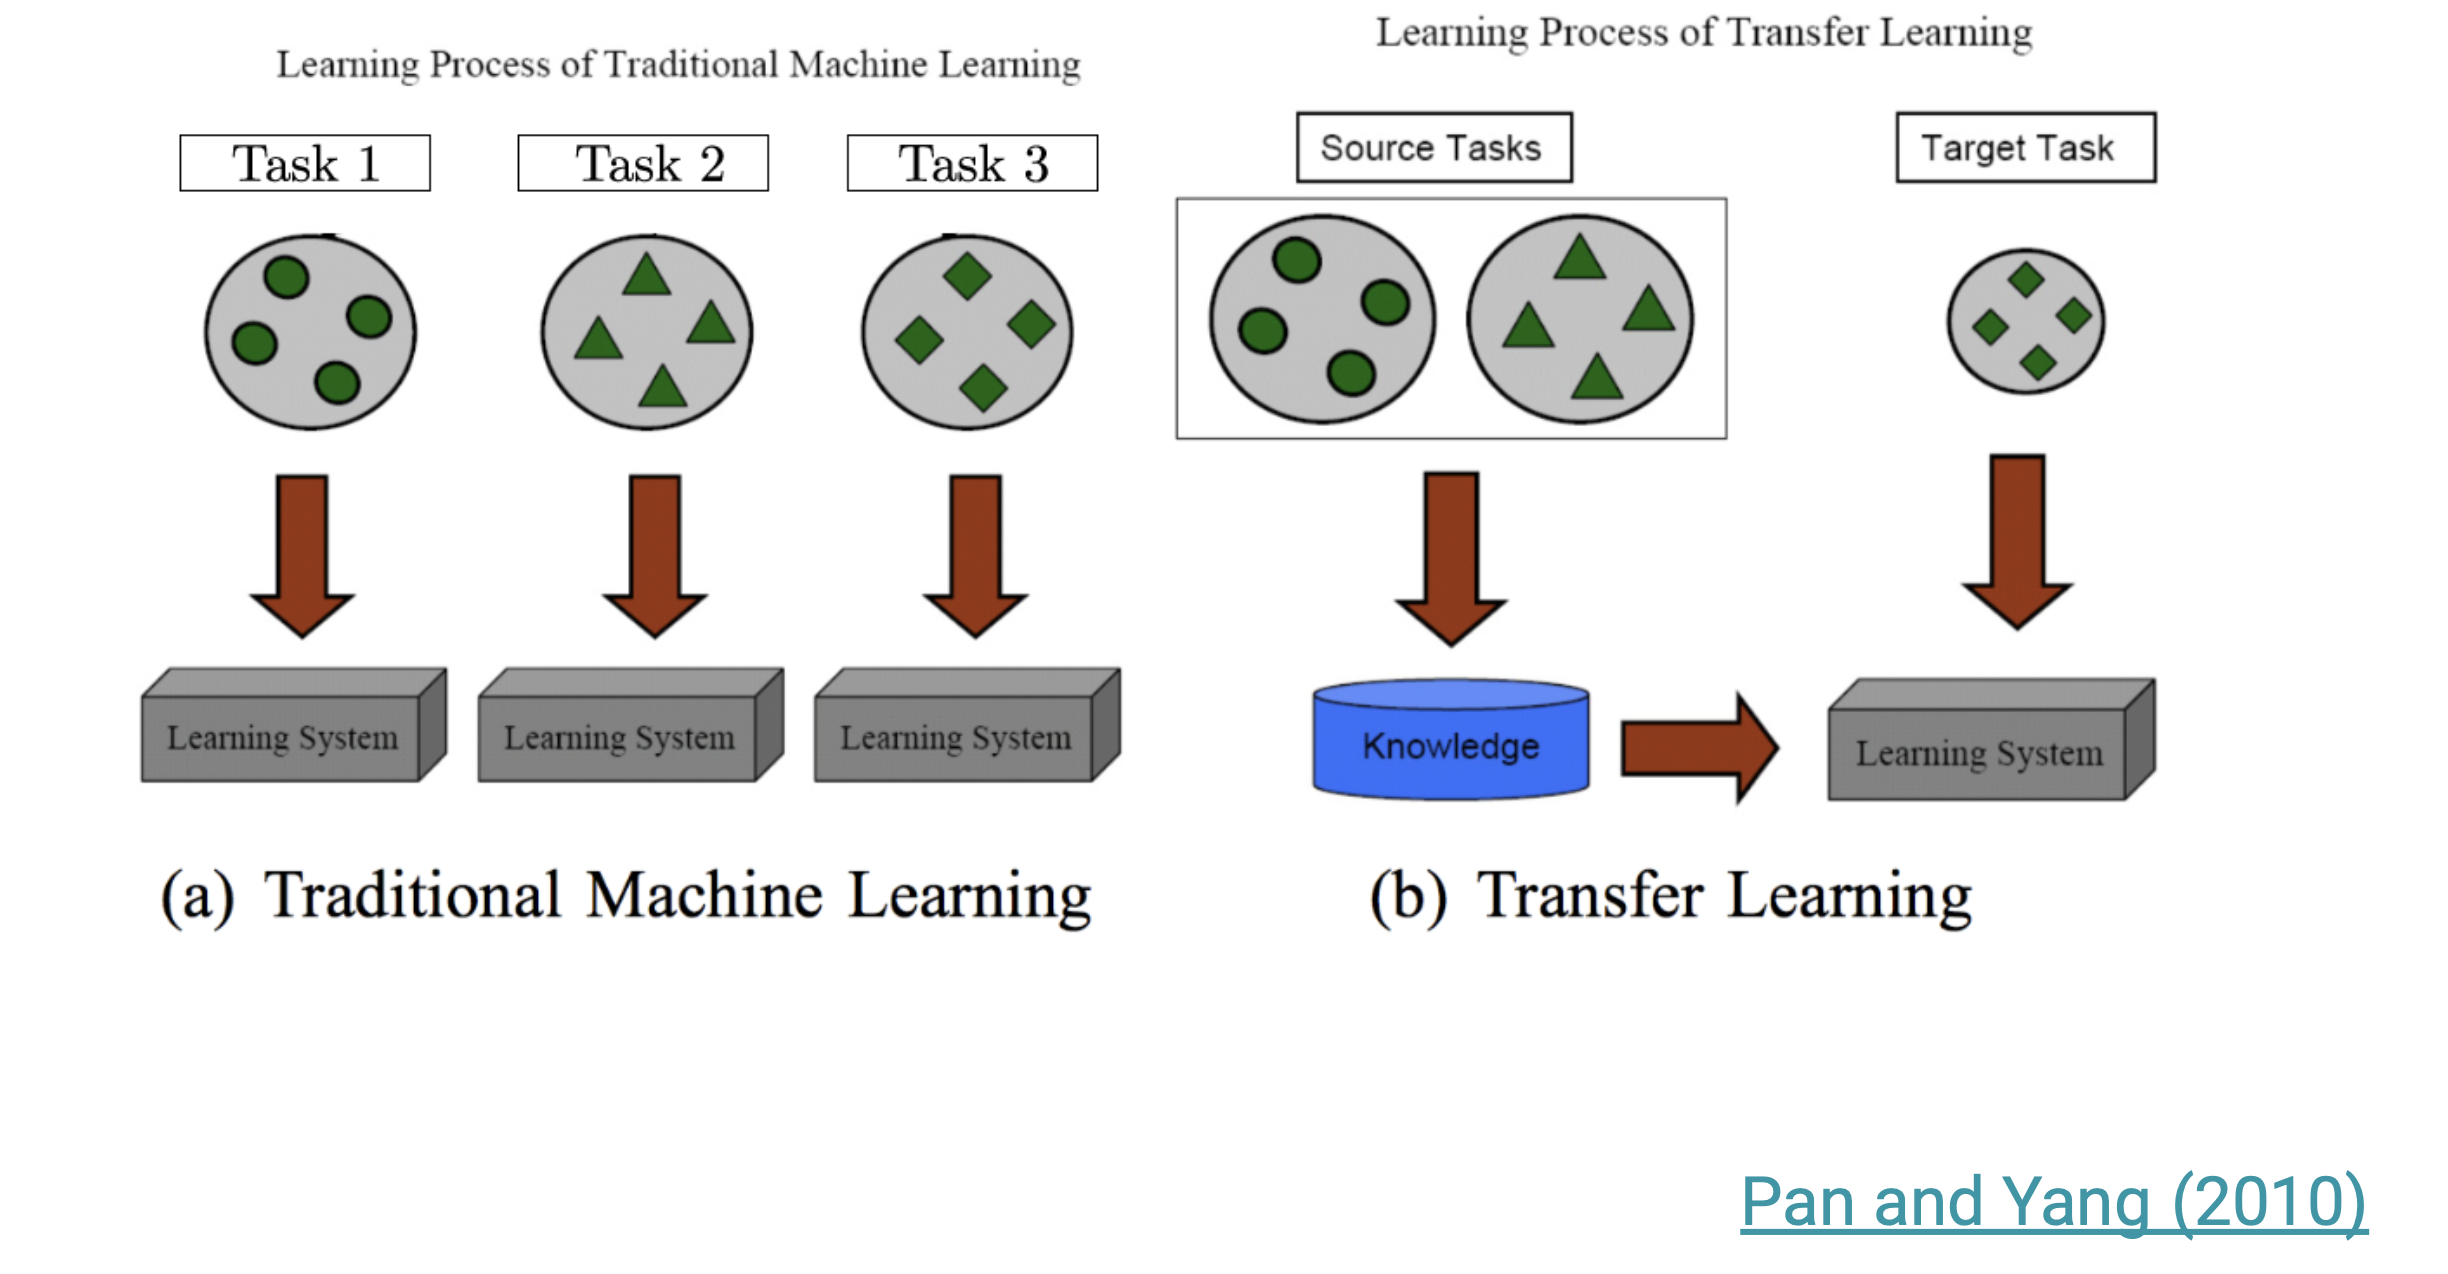

Transfer Learning in Natural Language Processing

*  Many NLP tasks share common knowledge about language (e.g. linguistic representations, structural similarities)
*  Tasks can inform each other — e.g. syntax and semantics
*  Annotated data is rare, make use of as much supervision as available
*  Empirically, transfer learning has resulted in SOTA for many supervised NLP tasks (e.g. classification, information extraction, Q&A, etc)

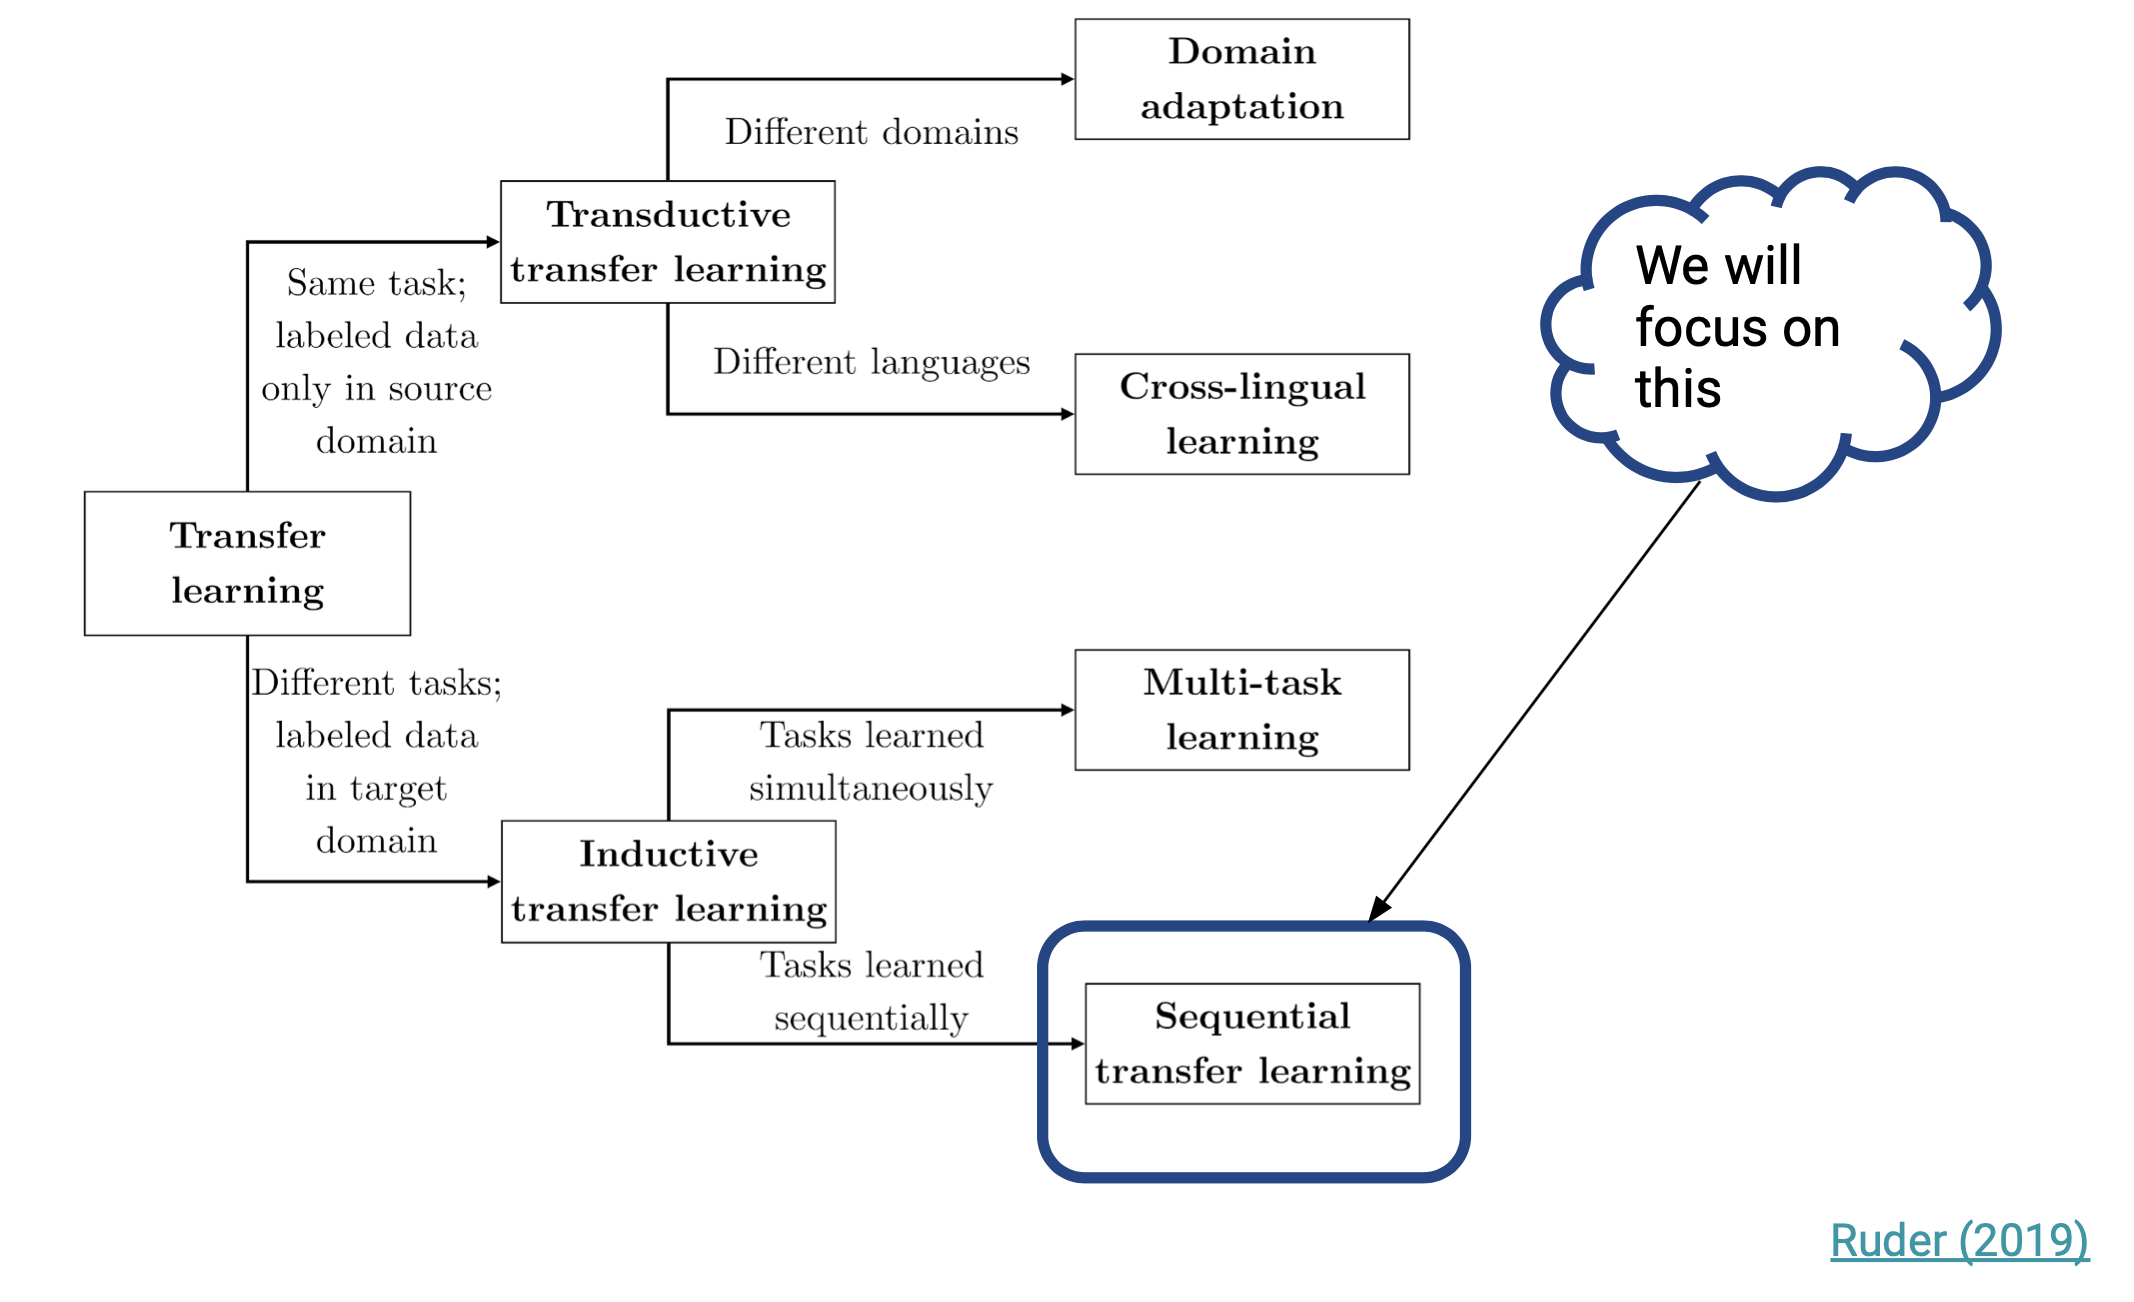

---
### Setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 58.3 MB/s 
     |████████████████████████████████| 7.6 MB 10.1 MB/s 


In [2]:
# Import required packages
import json
import numpy as np
import pandas as pd
from tqdm import notebook

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
import torch.optim as optim

from transformers import TrainingArguments
from transformers import BertModel, BertTokenizer
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_compute_metrics as compute_metrics

c.f.

  > `torch.utils.data.RandomSampler` samples elements randomly. If without replacement, then sample from a shuffled dataset. If with replacement, then user can specify num_samples to draw.
  
  > `torch.utils.data.SequentialSampler` samples elements sequentially, always in the same order.

  > `transformers.glue_convert_examples_to_features` loads a data file into a list of `InputFeatures` which is a single set of features of data.

  > `transformers.glue_compute_metrics` computes the specific evaluation metric based on task name given predictions and labels.



In [3]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/Labs/09

/content/drive/.shortcut-targets-by-id/1iwymnRox1MIjovxEjz1Y6-JUd2N9rDxD/Labs/09


---
### Transfer Learning
*Transfer learning* uses representation from one task to bootstrap learning for a data-poor task.

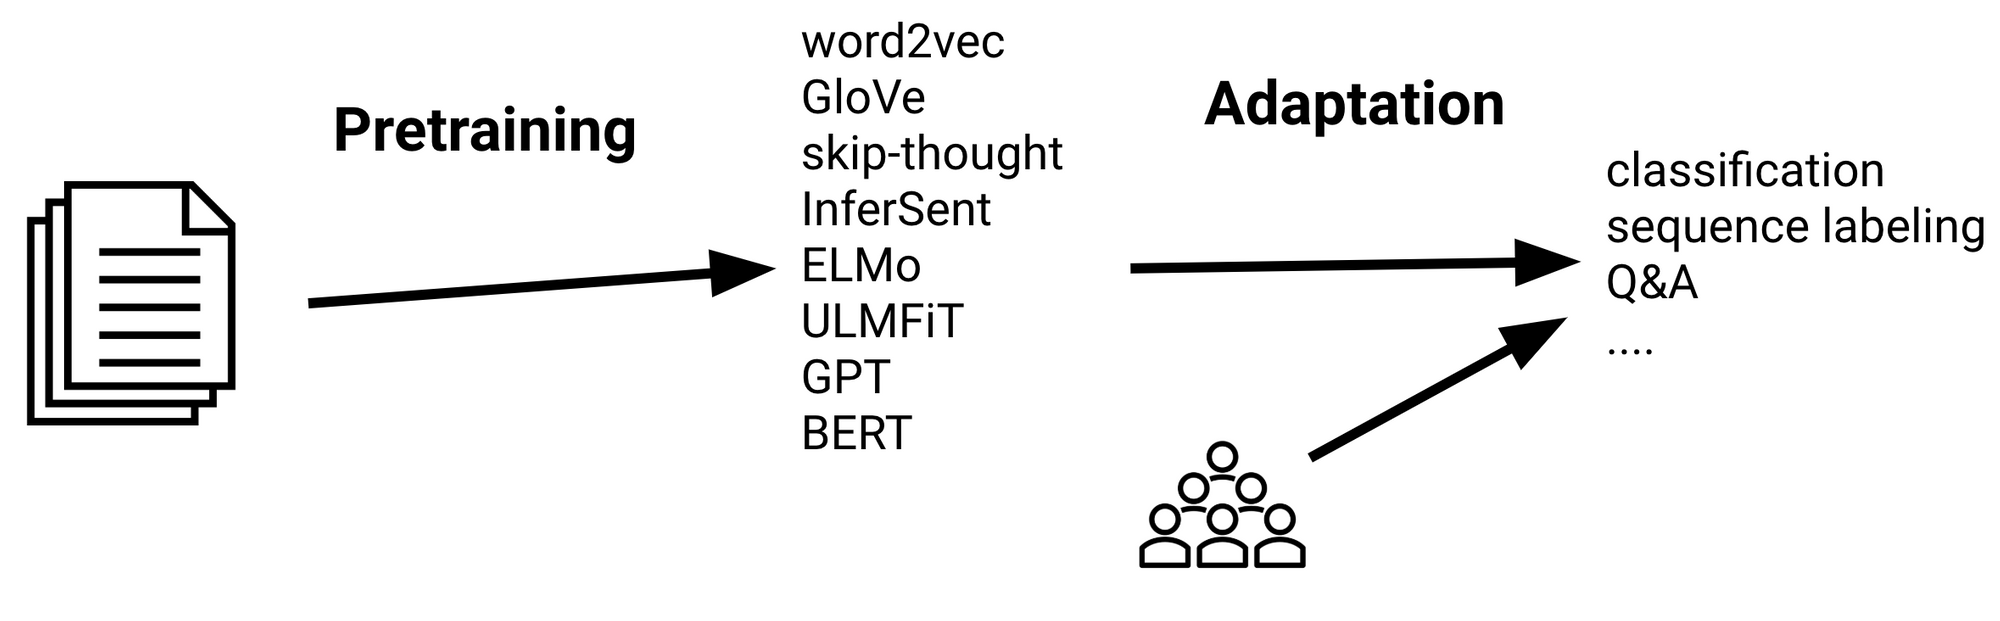

#### Fine-tuning on Sequence classification task
*Fine-tuning* is the process of using the extracted representations (features) to solve this downstream task (the task you're interested in).
#### Example Task: _Paraphrase Classification_

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Dataset: [Microsoft Research Paraphrase Corpus (MRPC)](https://www.microsoft.com/en-us/download/details.aspx?id=52398)

A text file containing 5800 pairs of sentences which have been extracted from news sources on the web, along with human annotations indicating whether each pair captures a paraphrase/semantic equivalence relationship.

In [6]:
!python download_glue_data.py --data_dir glue_data --tasks MRPC

Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!


**Data Loading:**

In [7]:
from transformers.data.processors.glue import MrpcProcessor

processor = MrpcProcessor()
train = processor.get_train_examples('glue_data/MRPC')

df = pd.DataFrame([json.loads(x.to_json_string()) for x in train])
df.sample(5)

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


,guid,text_a,text_b,label
1818,train-1819,""" Everything was decided in advance , "" said o...",""" It was a total mockery of justice , a parody...",0
2178,train-2179,"Abbas told the summit he would end the "" armed...","At Wednesday 's summit , Abbas pledged to end ...",1
1315,train-1316,"The dollar gained against the euro , yen and S...","The greenback rose steeply against the euro , ...",1
1782,train-1783,""" The United States welcomes a greater NATO ro...",""" The United States welcomes a greater NATO ro...",1
1282,train-1283,"This morning , at UM 's New York office , Coen...",Speaking to reporters at a New York news confe...,1


In [8]:
df.loc[df['label'] == '1']['text_a'][2]

'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .'

In [9]:
df.loc[df['label'] == '1']['text_b'][2]

"On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale ."

**Tokenization and Padding:**

In [10]:
features = convert_examples_to_features(train,
                                        tokenizer,
                                        label_list=['0', '1'],
                                        max_length=128,
                                        output_mode='classification')

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [11]:
f = features[1]

In [12]:
print("label: %d" % f.label)
print("([id]   \ttoken,\tattn mask, type)\n")
for i, a, t in zip(f.input_ids, f.attention_mask, f.token_type_ids):
    print("([%d]  \t%s,\t%d,\t%d)" % (i, tokenizer.ids_to_tokens[i], a, t))

label: 0
([id]   	token,	attn mask, type)

([101]  	[CLS],	1,	0)
([10684]  	Yu,	1,	0)
([2599]  	##ca,	1,	0)
([9717]  	##ip,	1,	0)
([1161]  	##a,	1,	0)
([2205]  	owned,	1,	0)
([11288]  	Dominic,	1,	0)
([1377]  	##k,	1,	0)
([112]  	',	1,	0)
([188]  	s,	1,	0)
([1196]  	before,	1,	0)
([4147]  	selling,	1,	0)
([1103]  	the,	1,	0)
([4129]  	chain,	1,	0)
([1106]  	to,	1,	0)
([19770]  	Safe,	1,	0)
([2787]  	##way,	1,	0)
([1107]  	in,	1,	0)
([1772]  	1998,	1,	0)
([1111]  	for,	1,	0)
([109]  	$,	1,	0)
([123]  	2,	1,	0)
([119]  	.,	1,	0)
([126]  	5,	1,	0)
([3775]  	billion,	1,	0)
([119]  	.,	1,	0)
([102]  	[SEP],	1,	0)
([10684]  	Yu,	1,	1)
([2599]  	##ca,	1,	1)
([9717]  	##ip,	1,	1)
([1161]  	##a,	1,	1)
([3306]  	bought,	1,	1)
([11288]  	Dominic,	1,	1)
([1377]  	##k,	1,	1)
([112]  	',	1,	1)
([188]  	s,	1,	1)
([1107]  	in,	1,	1)
([1876]  	1995,	1,	1)
([1111]  	for,	1,	1)
([109]  	$,	1,	1)
([5691]  	69,	1,	1)
([1495]  	##3,	1,	1)
([1550]  	million,	1,	1)
([1105]  	and,	1,	1)
([1962]  	sold,	1,	1)
(

**Convert to Tensors and build PyTorch dataset:**

In [13]:
train_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                              torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                              torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                              torch.tensor([f.label for f in features], dtype=torch.long))

In [14]:
train_dataset[0]

(tensor([  101,  7277,  2180,  5303,  4806,  1117,  1711,   117,  2292,  1119,
          1270,   107,  1103,  7737,   107,   117,  1104,  9938,  4267, 12223,
         21811,  1117,  2554,   119,   102, 11336,  6732,  3384,  1106,  1140,
          1112,  1178,   107,  1103,  7737,   107,   117,  7277,  2180,  5303,
          4806,  1117,  1711,  1104,  9938,  4267, 12223, 21811,  1117,  2554,
           119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

#### Model
BERT as Sequence Classifier using Transfer Learning

**Notation:**
- **Input** $$\textbf{x}=(x_{\text{CLS}},x^A_1,\ldots,x^A_{N_A},x_{\text{SEP}},x^B_1,\ldots,x^B_{N_B},x_{\text{SEP}})$$
- **Transformer (BERT)** $$B\textbf{(x)}\rightarrow (h_{\text{CLS}},h^A_1,\ldots,h^A_{N_A},h_{\text{SEP}},h^B_1,\ldots,h^B_{N_B},h_{\text{SEP}})$$

**Then Define:**
- **Weight matrix** $$W\in \mathbb{R}^{C\times d}$$
where $C$ is the number of classes and $d$ is the hidden dimension.
- **Class probabilities** $$p(c|\textbf{x})=\text{softmax}\left(Wh_{\text{CLS}}\right)$$

In [19]:
class BERTSequenceClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, num_classes)
        self.num_classes = num_classes
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        h, _, attn = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask, 
                               token_type_ids=token_type_ids).values()
        h_cls = h[:,0,:]
        logits = self.W(h_cls)
        return logits, attn

#### Training ('Fine-tuning') Loop

Just the standard training loop that you've seen and used several times now.

In [20]:
torch.manual_seed(0)

fine_tune_model = BERTSequenceClassifier(bert, 2)

In [21]:
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

num_train_epochs = 3

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

In [22]:
optimizer = optim.Adam([p for p in fine_tune_model.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

fine_tune_model.to(device)

# Train!
tr_loss, logging_loss = 0.0, 0.0
fine_tune_model.zero_grad()
for i in notebook.tqdm(range(num_train_epochs), desc="Epoch"):
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        fine_tune_model.train()
        batch = tuple(t.to(device) for t in batch)
        logits, _ = fine_tune_model(*batch[:-1])

        labels = batch[-1]
        loss = criterion(logits.view(-1, fine_tune_model.num_classes), labels.view(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fine_tune_model.parameters(), 1.0)

        tr_loss += loss.item()
        optimizer.step()
        fine_tune_model.zero_grad()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/115 [00:00<?, ?it/s]

Iteration:   0%|          | 0/115 [00:00<?, ?it/s]

Iteration:   0%|          | 0/115 [00:00<?, ?it/s]

c.f.
> `torch.nn.utils.clip_grad_norm` clips gradient norm of an iterable of parameters.The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.

#### Evaluation

In [ ]:
dev = processor.get_dev_examples('glue_data/MRPC')

features = convert_examples_to_features(dev,
                                        tokenizer,
                                        label_list=['0', '1'],
                                        max_length=128,
                                        output_mode='classification')

eval_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                             torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                             torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                             torch.tensor([f.label for f in features], dtype=torch.long))

In [ ]:
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=8)

# Eval!
eval_loss = 0.0
nb_eval_steps = 0
preds = []
all_labels = []

for batch in notebook.tqdm(eval_dataloader, desc="Evaluating"):
    fine_tune_model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        logits, attn = fine_tune_model(*batch[:-1])

        labels = batch[-1]
        eval_loss += criterion(logits.view(-1, fine_tune_model.num_classes), labels.view(-1)).mean().item()

    nb_eval_steps += 1
    preds.append(logits.view(-1, fine_tune_model.num_classes).detach().cpu())
    all_labels.append(labels.view(-1).detach().cpu())

eval_loss = eval_loss / nb_eval_steps

preds = torch.cat(preds, 0).numpy()
preds = np.argmax(preds, axis=1)

all_labels = torch.cat(all_labels, 0).numpy()

result = compute_metrics('mrpc', preds, all_labels)
print('Validation loss after {} epoch = {:.4f} ACC: {:.4f} f1: {:.4f}'.format(num_train_epochs, eval_loss, result['acc'], result['f1']))

#### Comparison (acc/f1):
Below table shows baseline performance on the General Language
Understanding Evaluation (GLUE) task test sets.

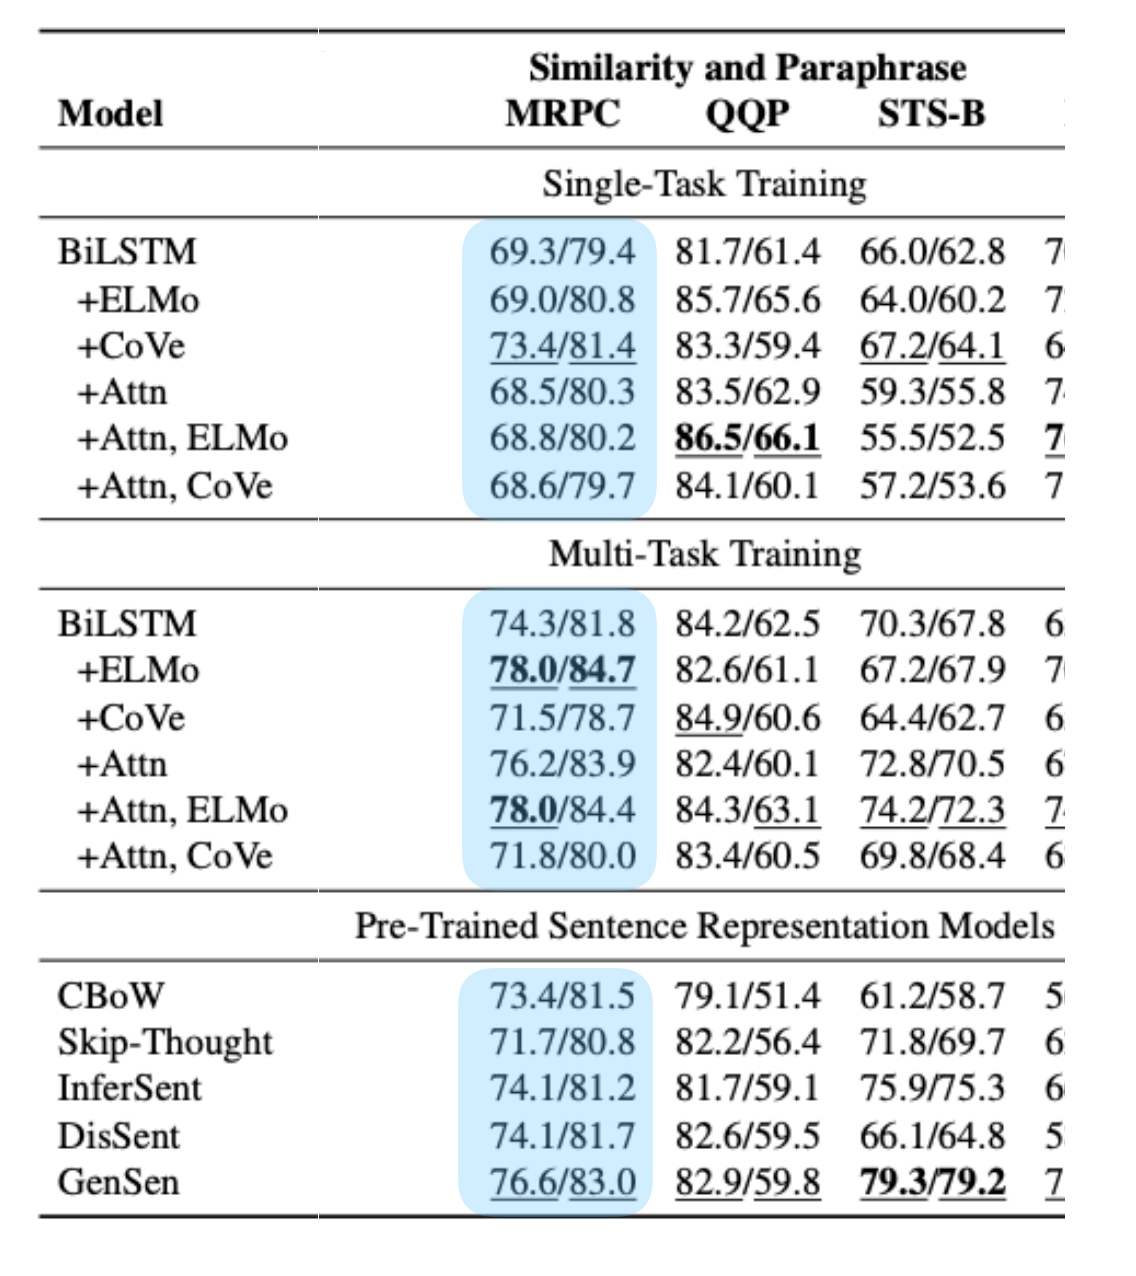


(Adapted from [Wang et al 2018](https://openreview.net/pdf?id=rJ4km2R5t7))

c.f.  

> *GLUE* is a collection of resources for training, evaluating, and analyzing natural language understanding systems.

> ##### GLUE Benchmark Leaderboards

- [Leaderboard](https://gluebenchmark.com/leaderboard)

- [SuperGLUE](https://super.gluebenchmark.com/leaderboard)

---
### Freezing
We can freeze the weights of the model. *Freezing* means the gradients will not backpropagate into these weights.

By doing this, you can think about the model as a *feature extractor*. This feature extractor outputs a representation of an input.

To illustrate this, we'll use our pretrained model (BERT), to solve the MRPC classification task.

There are two types of finetuning.

1. *Frozen* feature_extractor

  In the first type we pretrain with the FROZEN feature_extractor and NEVER unfreeze it during finetuning.

2. *Unfrozen* feature_extractor

  In the second, we finetune with a FROZEN feature_extractor for a few epochs, then unfreeze the feature extractor and finish training.



In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

#### Unfrozen
Now we'll learn how to train using the "unfrozen" approach.

In this approach we'll:



1.   keep the feature_extract frozen for a few epochs

2.   Unfreeze it

3. Finish training

In [ ]:
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.W = Identity()
        self.num_classes = num_classes
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        h, _, attn = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask, 
                               token_type_ids=token_type_ids)
        h_cls = h[:, 0]
        logits = self.W(h_cls)
        return logits, attn

In [ ]:
def init_bert(num_classes):
    model = BERTClassifier(bert, num_classes)    
    return model

In [ ]:
def init_finetune_model(bert, num_classes):
    fine_tune_model = nn.Linear(bert.config.hidden_size, num_classes)
    return fine_tune_model

In [ ]:
torch.manual_seed(0)

BERT_feature_extractor = init_bert(num_classes=2)
finetune_model = init_finetune_model(bert, num_classes=2)

In [ ]:
num_train_epochs = 3
num_frozen_epochs = 2
num_unfrozen_epochs = num_train_epochs - num_frozen_epochs

In [ ]:
# Train
# keep frozen for 2 epochs
freeze_model(BERT_feature_extractor)
BERT_feature_extractor.W = finetune_model
model = BERT_feature_extractor

model.to(device)

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=2e-05, eps=1e-08)
criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

model.to(device)

tr_loss, logging_loss = 0.0, 0.0
model.zero_grad()

for i in notebook.tqdm(range(num_frozen_epochs), desc="Frozen Epoch"):
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        logits, _ = model(*batch[:-1])
        
        labels = batch[-1]
        loss = criterion(logits.view(-1, model.num_classes), labels.view(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        tr_loss += loss.item()
        optimizer.step()
        model.zero_grad()

In [ ]:
# Eval!
eval_loss = 0.0
nb_eval_steps = 0
preds = []
all_labels = []

for batch in notebook.tqdm(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        logits, attn = model(*batch[:-1])

        labels = batch[-1]
        eval_loss += criterion(logits.view(-1, model.num_classes), labels.view(-1)).mean().item()

    nb_eval_steps += 1
    preds.append(logits.view(-1, model.num_classes).detach().cpu())
    all_labels.append(labels.view(-1).detach().cpu())

eval_loss = eval_loss / nb_eval_steps

preds = torch.cat(preds, 0).numpy()
preds = np.argmax(preds, axis=1)

all_labels = torch.cat(all_labels, 0).numpy()

result = compute_metrics('mrpc', preds, all_labels)
print('Validation loss after {} frozen epoch = {:.4f} ACC: {:.4f} f1: {:.4f}'.format(num_frozen_epochs, eval_loss, result['acc'], result['f1']))

In [ ]:
# unfreeze
unfreeze_model(model)
# set optimizer and criterion
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=2e-05, eps=1e-08)
criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

tr_loss, logging_loss = 0.0, 0.0
model.zero_grad()

for i in notebook.tqdm(range(num_unfrozen_epochs), desc="Unfrozen Epoch"):
    epoch_iterator = notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        logits, _ = model(*batch[:-1])
        
        labels = batch[-1]
        loss = criterion(logits.view(-1, model.num_classes), labels.view(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        tr_loss += loss.item()
        optimizer.step()
        model.zero_grad()

In [ ]:
# Eval!
eval_loss = 0.0
nb_eval_steps = 0
preds = []
all_labels = []

for batch in notebook.tqdm(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        logits, attn = model(*batch[:-1])

        labels = batch[-1]
        eval_loss += criterion(logits.view(-1, model.num_classes), labels.view(-1)).mean().item()

    nb_eval_steps += 1
    preds.append(logits.view(-1, model.num_classes).detach().cpu())
    all_labels.append(labels.view(-1).detach().cpu())

eval_loss = eval_loss / nb_eval_steps

preds = torch.cat(preds, 0).numpy()
preds = np.argmax(preds, axis=1)

all_labels = torch.cat(all_labels, 0).numpy()

result = compute_metrics('mrpc', preds, all_labels)
print('Validation loss after {} frozen and {} unfrozen epoch = {:.4f} ACC: {:.4f} f1: {:.4f}'.format(num_frozen_epochs,
                                                                                                     num_unfrozen_epochs, eval_loss, result['acc'], result['f1']))

---
## References
- DS-GA 1011 NLP with Representation Learning Fall 2020
- [Transfer Learning - Machine Learning's Next Frontier](https://ruder.io/transfer-learning/)